# The _EUV Snapshot Imaging Spectrograph_

_Roy T. Smart, Charles C. Kankelborg, and Jacob D. Parker_

In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
import astropy.units as u
import astropy.nddata
import pandas
import IPython.display
from kgpy import vector, optics, format as fmt, observatories, plot, moment
import esis

In [3]:
warnings.filterwarnings('ignore')
pandas.options.display.max_colwidth=75


In [4]:
esis_optics_small = esis.optics.design.final(
    pupil_samples=10,
    pupil_is_stratified_random=True,
    field_samples=10,
#     field_is_stratified_random=True,
    all_channels=False,
)
%time rays_small = esis_optics_small.rays_output

num 2d secant iterations 3
Wall time: 583 ms


In [5]:
esis_optics = esis.optics.design.final(
    pupil_samples=21,
    field_samples=21,
#     pupil_is_stratified_random=True,
    all_channels=False,
)
# %prun -s "cumulative" rays_input = esis_optics.system.rays_input
# %time rays_input = esis_optics.system.rays_input
# %prun -s "cumtime" rays = esis_optics.rays_output
%time rays = esis_optics.rays_output

num 2d secant iterations 3
Wall time: 6.38 s


## Optical Layout

<IPython.core.display.Javascript object>


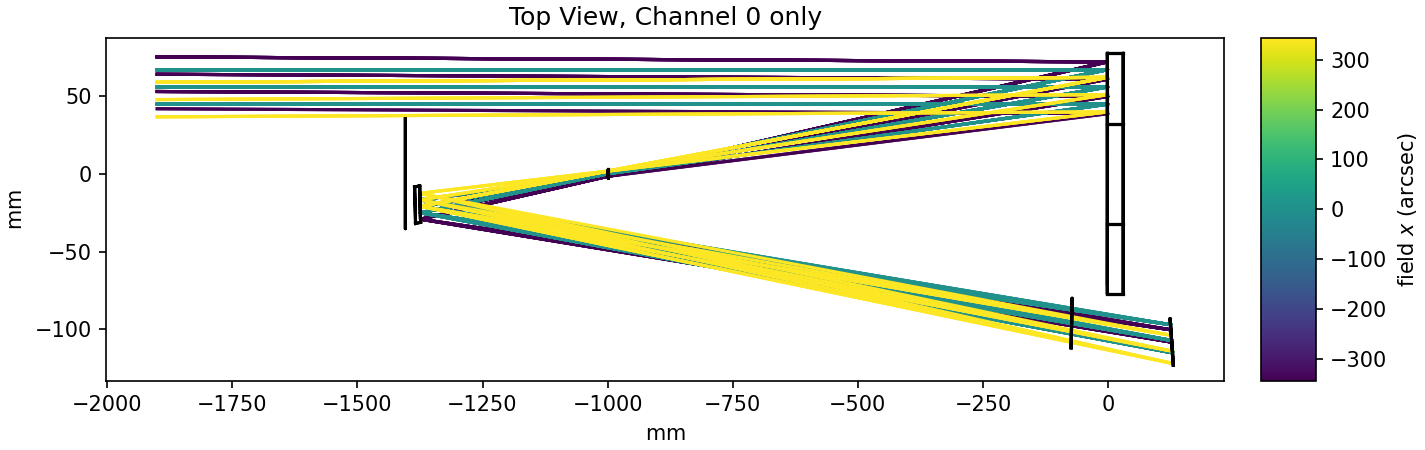

num 2d secant iterations 3


<IPython.core.display.Javascript object>


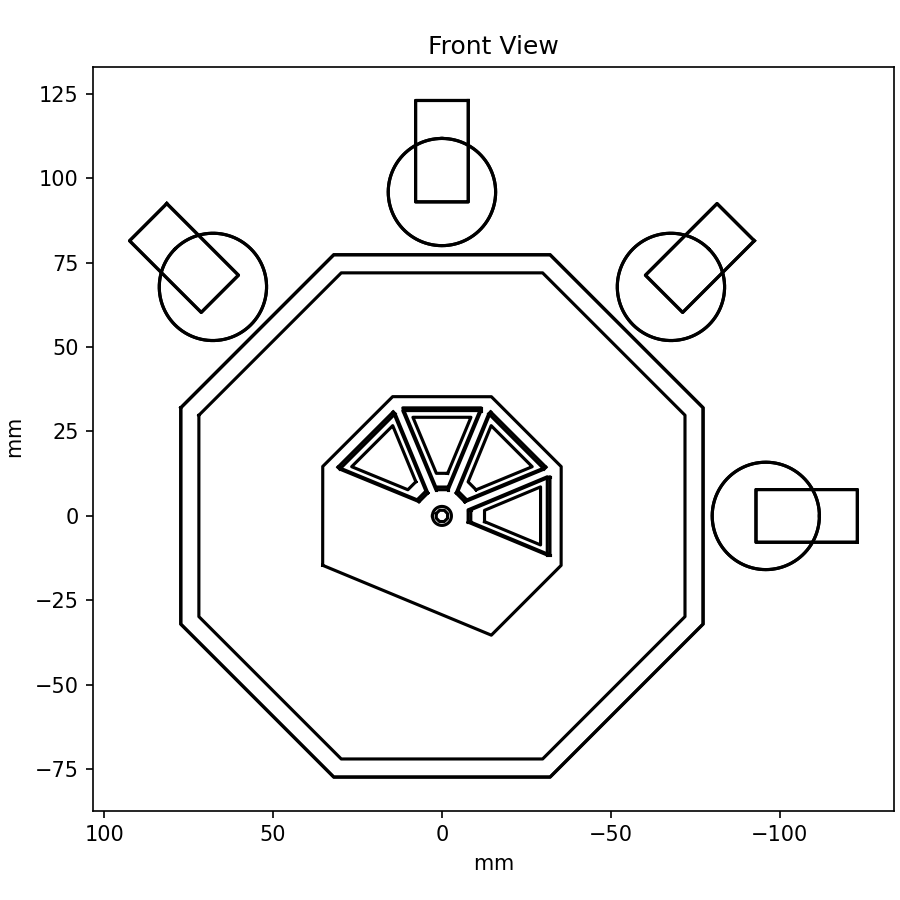

In [6]:
color_axis = optics.rays.Rays.axis.field_x
fig_layout, ax_layout = plt.subplots(figsize=(9.5, 3), constrained_layout=True)
esis.optics.design.final(field_samples=3, pupil_samples=5, all_channels=False).system.plot(
    ax=ax_layout, 
    components=('z', 'x'),
    color_axis=color_axis,
#     plot_vignetted=True
    
)
_ = ax_layout.set_title('Top View, Channel 0 only')

fig_bore, ax_bore = plt.subplots(figsize=(6, 6), constrained_layout=True)
ax_bore.invert_xaxis()
esis.optics.design.final().system.plot(
    ax=ax_bore, 
    plot_rays=False,
)
_ = ax_bore.set_title('Front View')
ax_bore.set_aspect('equal')

<IPython.core.display.Javascript object>


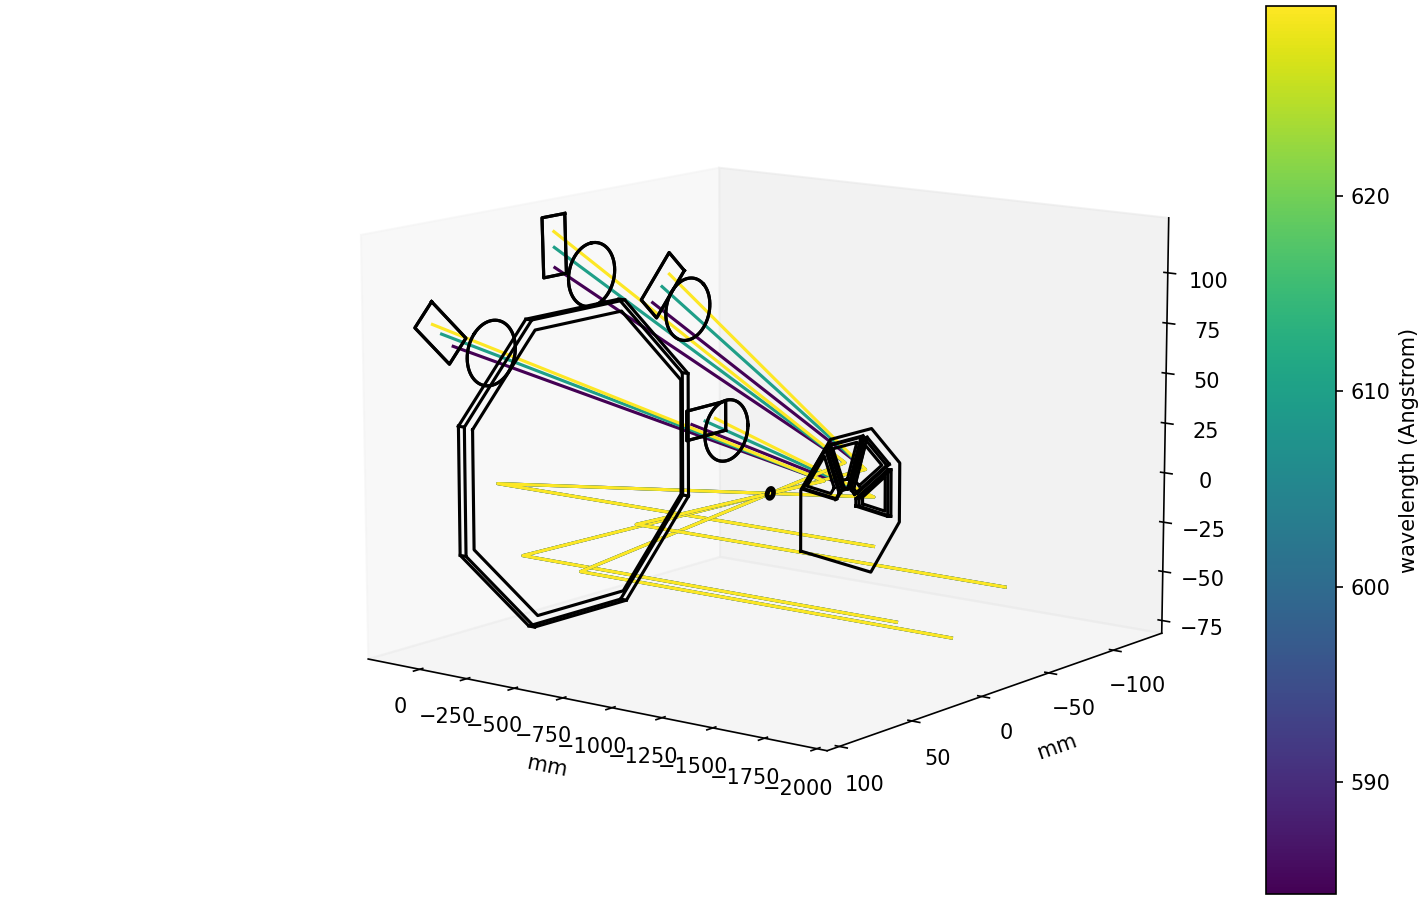

num 2d secant iterations 3


In [17]:
fig_layout_3d = plt.figure(figsize=(9.5,6), constrained_layout=True)
ax_layout_3d = fig_layout_3d.add_subplot(111, projection='3d')
ax_layout_3d.grid(False)
esis.optics.design.final(field_samples=1, pupil_samples=1).system.plot(
    ax=ax_layout_3d, 
    components=('z', 'x'),
    component_z='y',
#     color_axis=optics.rays.Rays.axis.field_x,
#     plot_vignetted=True
);

<IPython.core.display.Javascript object>


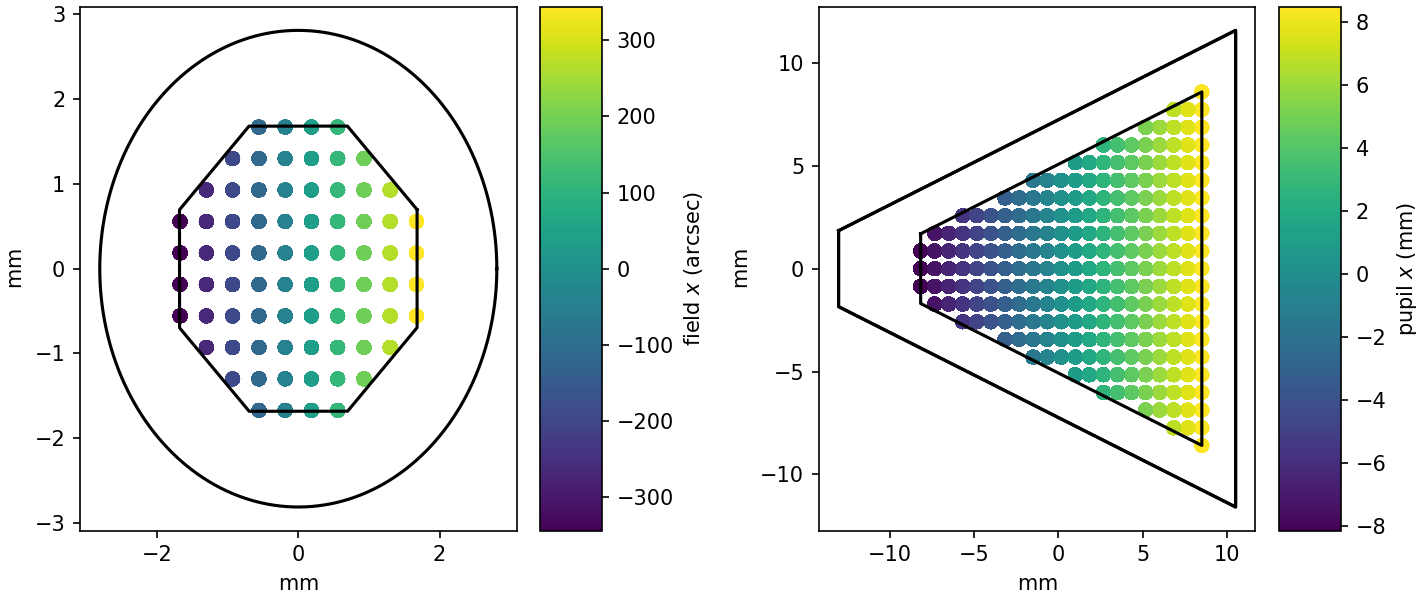

In [9]:
fig_fp, ax_fp = plt.subplots(ncols=2, figsize=(9.5, 4), constrained_layout=True)
esis_optics_small.system.plot_footprint(
    ax=ax_fp[0], 
    surf=esis_optics.field_stop.surface,
    color_axis=rays_small.axis.field_x,
);
esis_optics.system.plot_footprint(
    ax=ax_fp[1], 
    surf=esis_optics.grating.surface,
    color_axis=rays_small.axis.pupil_x,
);

## Point-spread Function

In [13]:
%%time
rays_psf = esis.optics.design.final(
    pupil_samples=100,
    pupil_is_stratified_random=True,
    field_samples=5,
    all_channels=False,
).rays_output

num 2d secant iterations 3
Wall time: 20.2 s


<IPython.core.display.Javascript object>


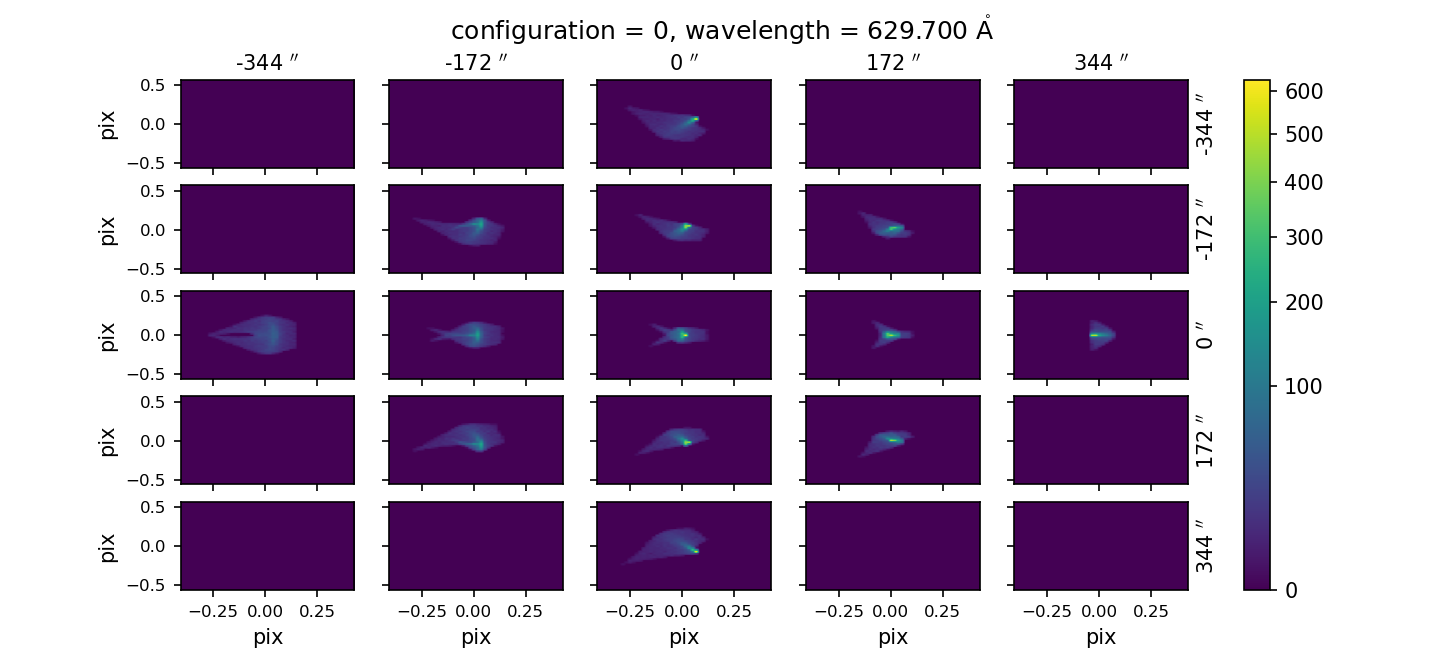

<IPython.core.display.Javascript object>


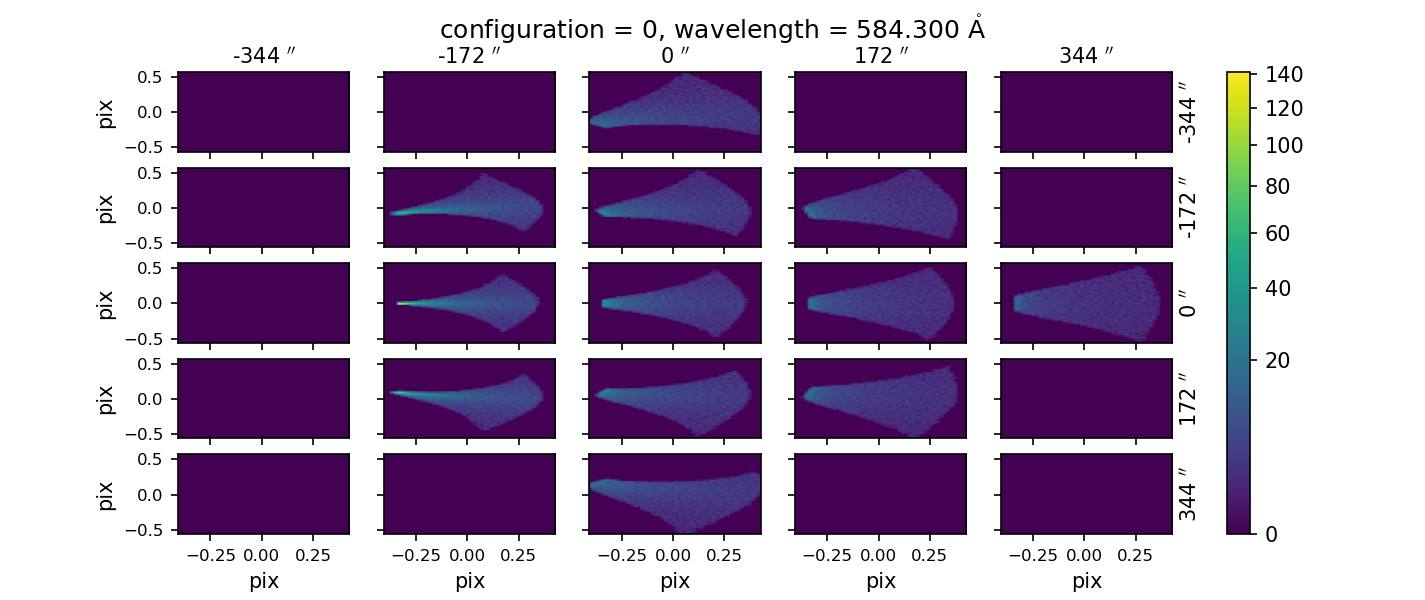

In [14]:
# bins = rays_psf.input_pupil_x.shape[~0] // 2
bins = rays_psf.input_grid.pupil.num_samples_normalized.x // 2

fig_630 = rays_psf.plot_pupil_hist2d_vs_field(wavlen_index=~0, norm=matplotlib.colors.PowerNorm(1/2), bins=bins, )
fig_630.set_figheight(4)
fig_630.set_figwidth(9.5)

fig_584 = rays_psf.plot_pupil_hist2d_vs_field(wavlen_index=0, norm=matplotlib.colors.PowerNorm(1/2), bins=bins, )
fig_584.set_figheight(4)
fig_584.set_figwidth(9.5)

<IPython.core.display.Javascript object>


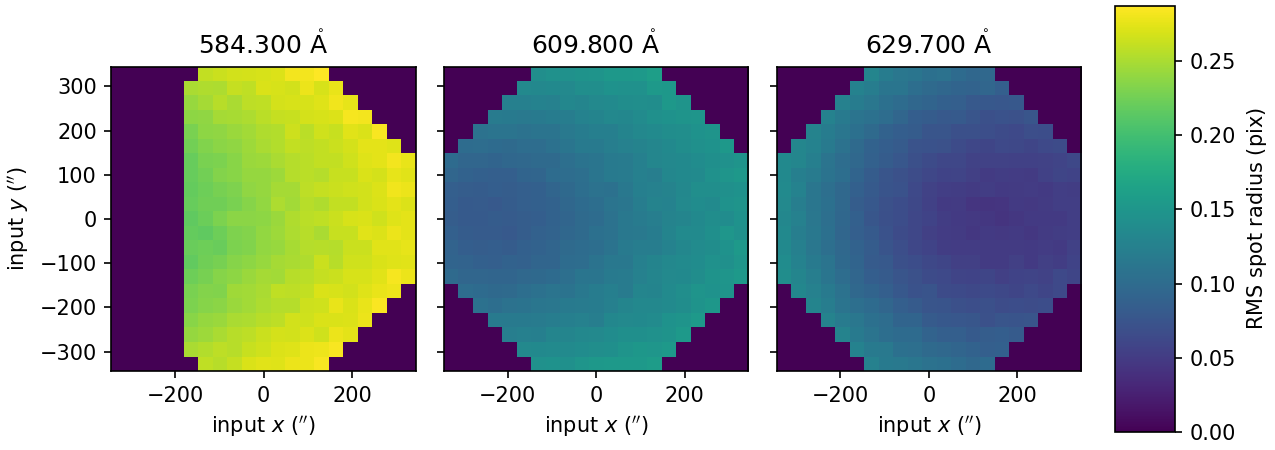

In [15]:
fig_sz, axs_sz = plt.subplots(ncols=3, figsize=(8.5, 3), sharex=True, sharey=True, constrained_layout=True)
_ = rays.plot_spot_size_vs_field(axs=axs_sz)

## Vignetting

In [16]:
vignetting_linear = rays.vignetting(polynomial_degree=1)
vignetting_linear.model().dataframe.T.style.set_properties(width='200px')

In [17]:
vignetting_quadratic = rays.vignetting(polynomial_degree=2)
vignetting_quadratic.model().dataframe.T.style.set_properties(width='200px')

<IPython.core.display.Javascript object>


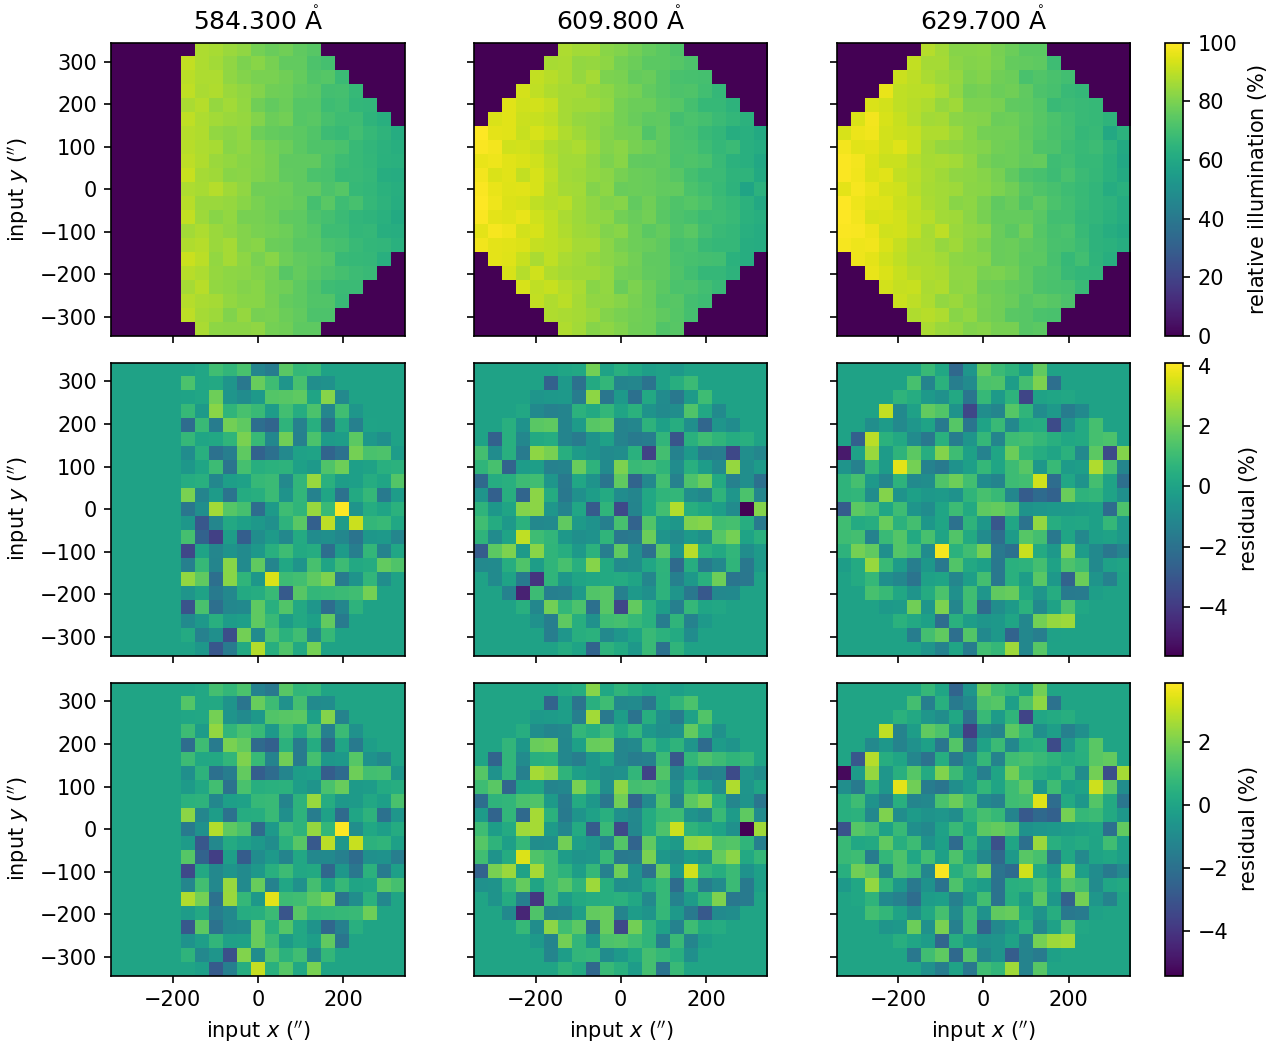

In [18]:
fig_vig, axs_vig = plt.subplots(nrows=3, ncols=3, figsize=(8.5, 7), sharex=True, sharey=True, constrained_layout=True)
_ = vignetting_linear.plot_unvignetted(axs=axs_vig[0], use_xlabels=False)
_ = vignetting_linear.plot_residual(axs=axs_vig[1], use_titles=False, use_xlabels=False)
_ = vignetting_quadratic.plot_residual(axs=axs_vig[2], use_titles=False)

## Distortion

In [19]:
distortion_linear = rays.distortion(polynomial_degree=1)
distortion_quadratic = rays.distortion(polynomial_degree=2)
distortion_large = rays.distortion()

In [20]:
distortion_quadratic.model().dataframe.T.style.set_properties(width='200px')

In [21]:
distortion_quadratic.model(inverse=True).dataframe.T.style.set_properties(width='200px')

<IPython.core.display.Javascript object>


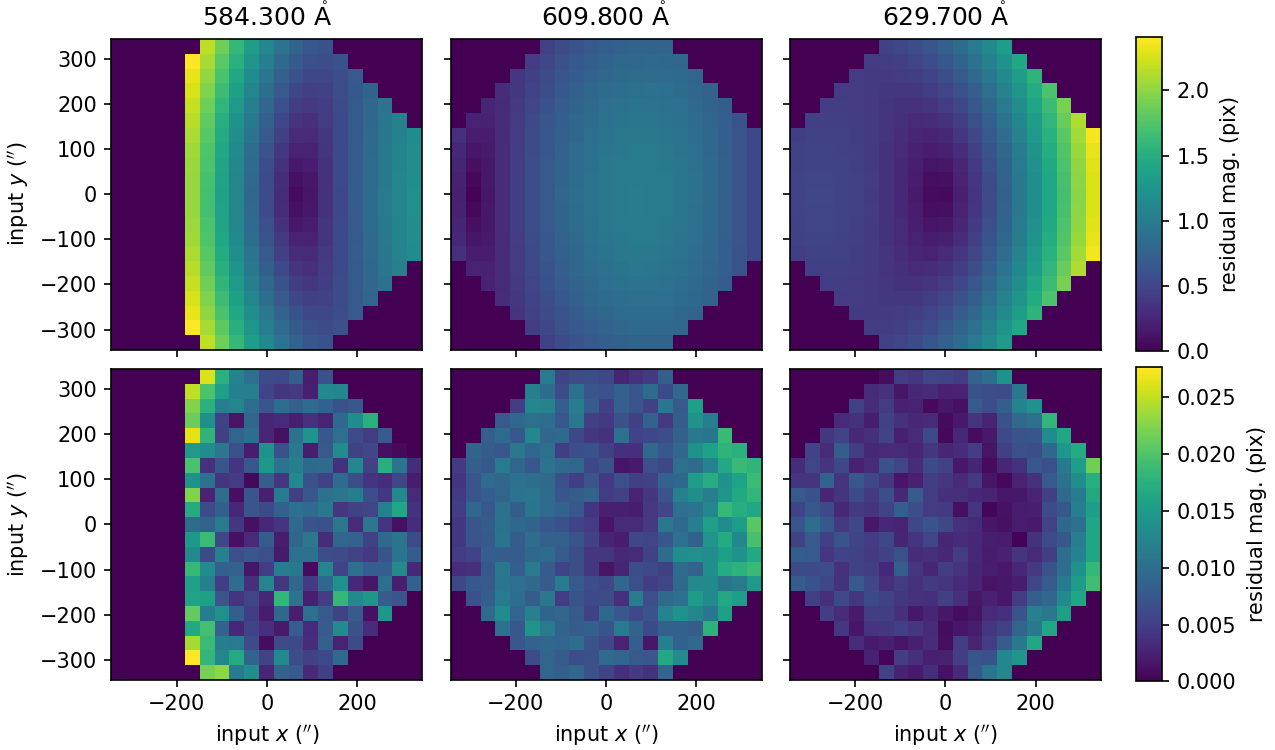

In [22]:
fig_dist_res, axs_dist_res = plt.subplots(nrows=2, ncols=3, figsize=(8.5, 5), sharex=True, sharey=True, constrained_layout=True)
_ = distortion_linear.plot_residual(axs=axs_dist_res[0], other=distortion_large, use_xlabels=False)
_ = distortion_quadratic.plot_residual(axs=axs_dist_res[1], other=distortion_large, use_titles=False)

## Level 0 Dataset

In [23]:
%time level_0 = esis.flight.level_0()

Wall time: 27.3 s


<IPython.core.display.Javascript object>


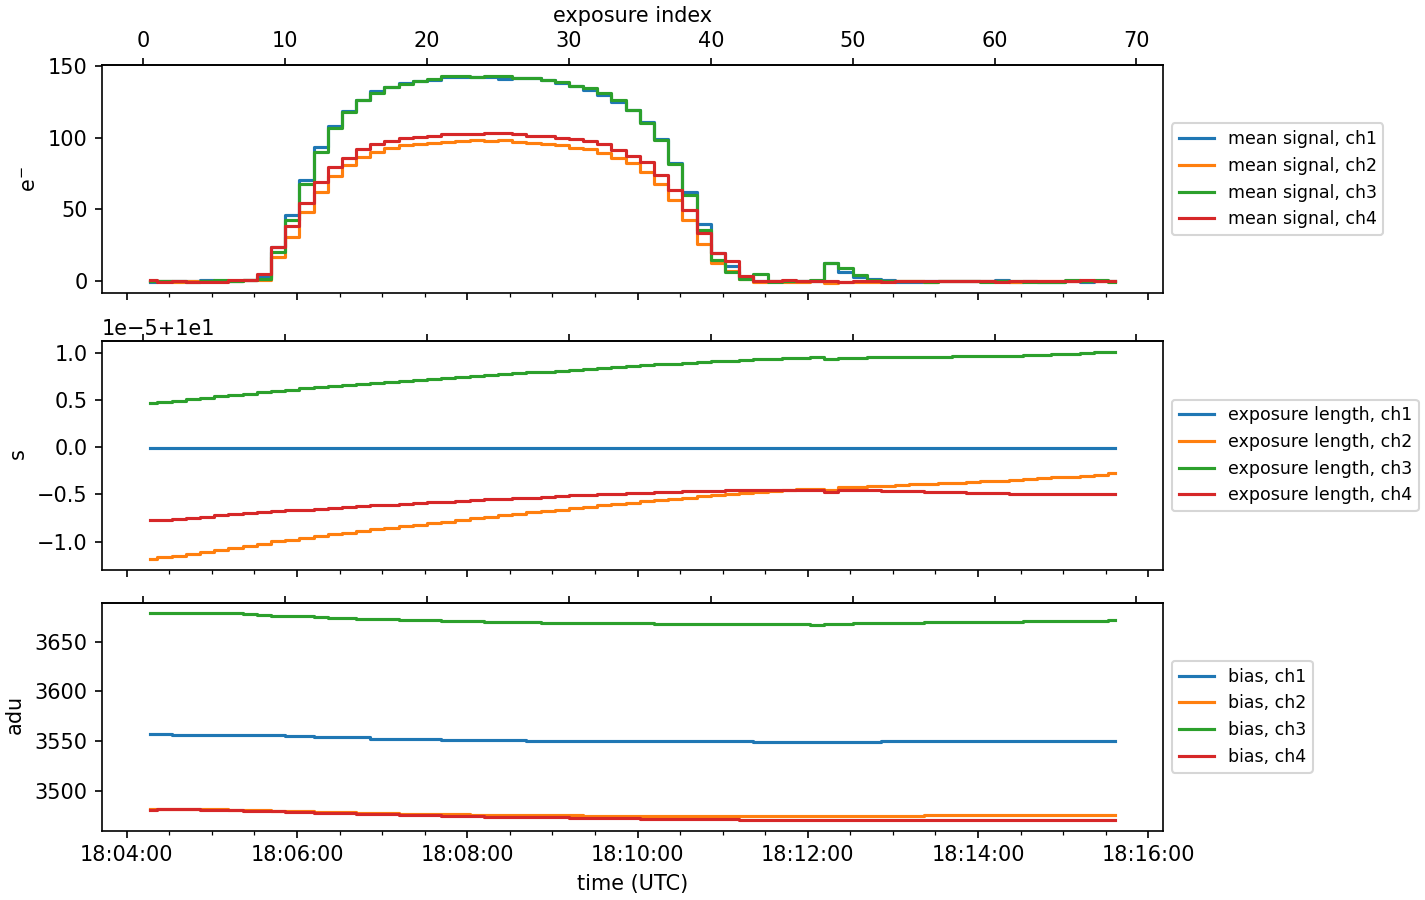

In [24]:
fig_lev0_vs_t, axs_lev0_vs_t = plt.subplots(nrows=3, figsize=(9.5, 6), sharex=True, constrained_layout=True)
ax2_lev0_vs_t = level_0.add_index_axis_to_shared_time_axes(axs_lev0_vs_t)
level_0.plot_exposure_stats_vs_index(axs_lev0_vs_t);
for ax in axs_lev0_vs_t:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

<IPython.core.display.Javascript object>


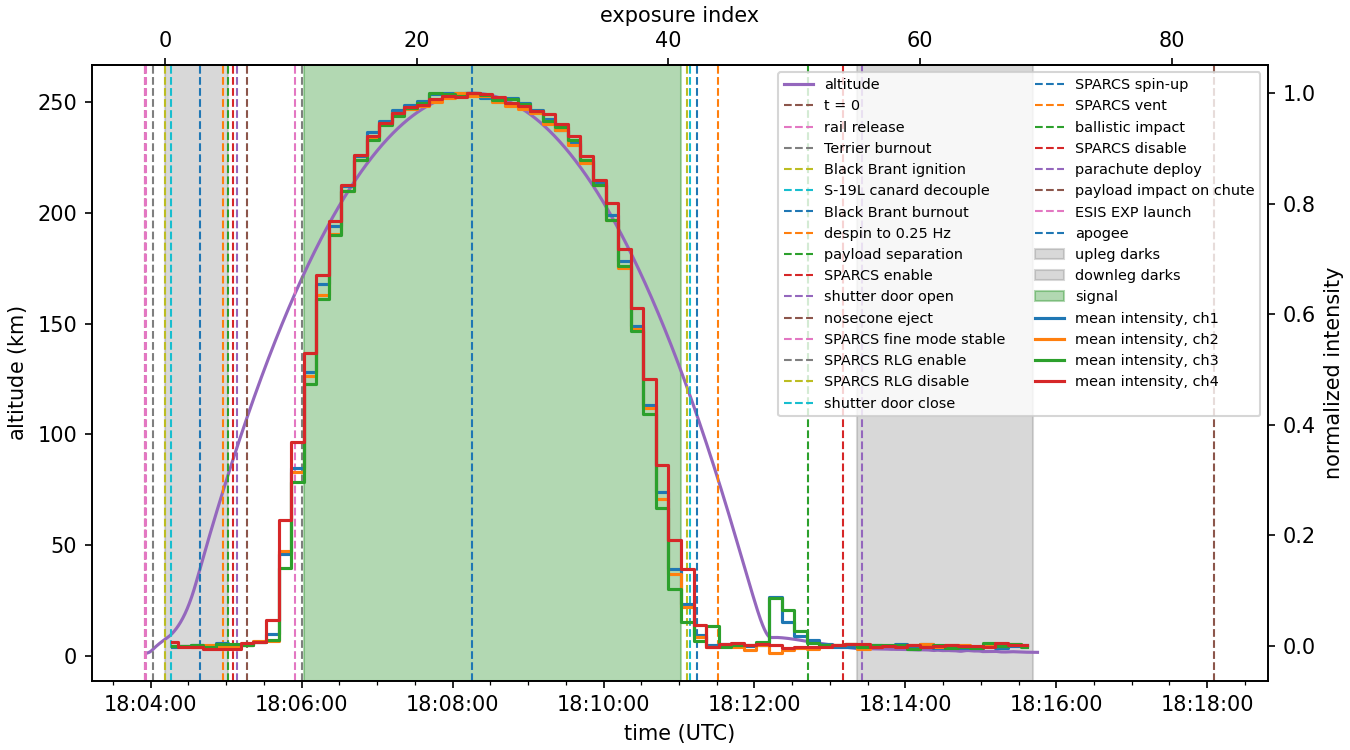

In [25]:
fig_sig_and_alt, ax_sig_and_alt = plt.subplots(figsize=(9,5), constrained_layout=True)
level_0.plot_altitude_and_signal_vs_time(ax=ax_sig_and_alt);
level_0.timeline.plot(ax=ax_sig_and_alt, time_start=level_0.trajectory.time_start);
level_0.trajectory.plot_apogee(ax=ax_sig_and_alt);
level_0.plot_dark_spans(ax=ax_sig_and_alt);
level_0.plot_signal_span(ax=ax_sig_and_alt);
level_0.add_index_axis_to_time_axis(ax_sig_and_alt);
fig_sig_and_alt.legend(
    loc='upper right', 
    bbox_to_anchor=(1, 1),
    bbox_transform=ax_sig_and_alt.transAxes, 
    fontsize='x-small', 
    ncol=2,
);

<IPython.core.display.Javascript object>


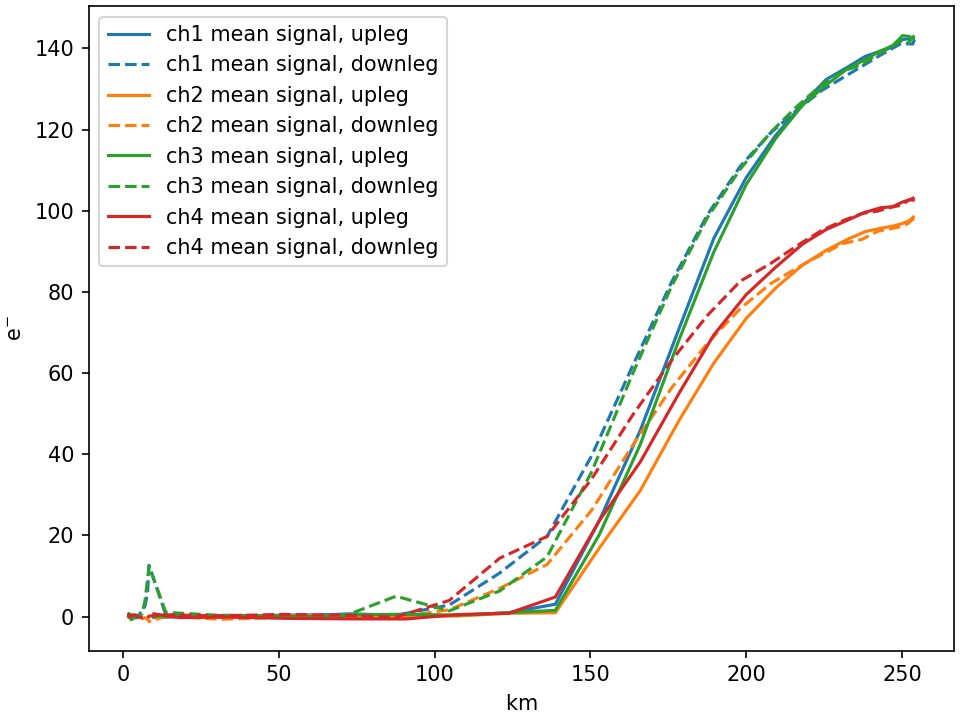

In [26]:
fig_sig_vs_alt, ax_sig_vs_alt = plt.subplots(constrained_layout=True)
level_0.plot_signal_vs_altitude(ax=ax_sig_vs_alt, plot_model=False);
ax_sig_vs_alt.legend();

<IPython.core.display.Javascript object>


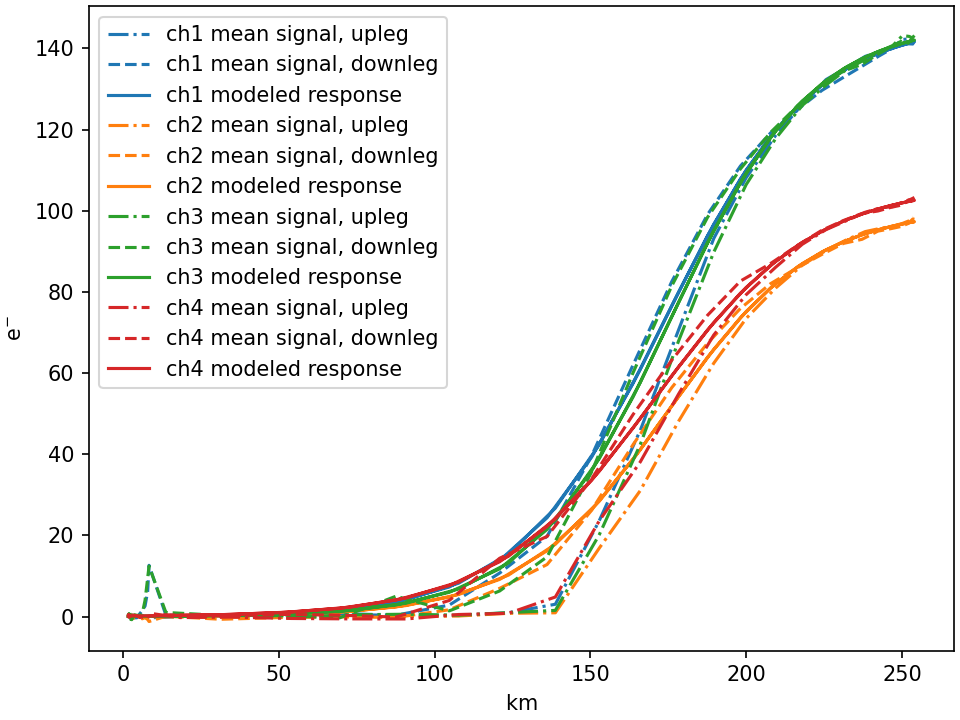

In [27]:
fig2_sig_vs_alt, ax2_sig_vs_alt = plt.subplots(constrained_layout=True)
level_0.plot_signal_vs_altitude(ax=ax2_sig_vs_alt);
ax2_sig_vs_alt.legend();

In [28]:
level_0.time_start

<Time object: scale='utc' format='isot' value=2019-09-30T18:03:55.725>

<IPython.core.display.Javascript object>


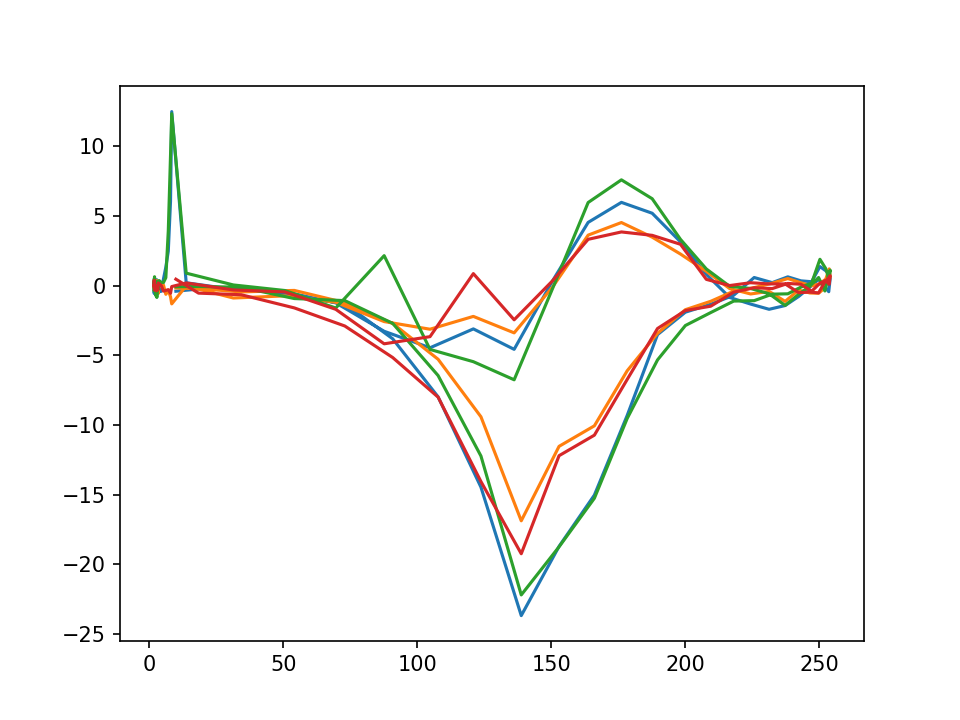

In [29]:
plt.figure()
plt.plot(level_0.altitude, level_0.intensity_electrons.mean(level_0.axis.xy) - level_0.absorption_atmosphere(level_0.altitude))

<IPython.core.display.Javascript object>


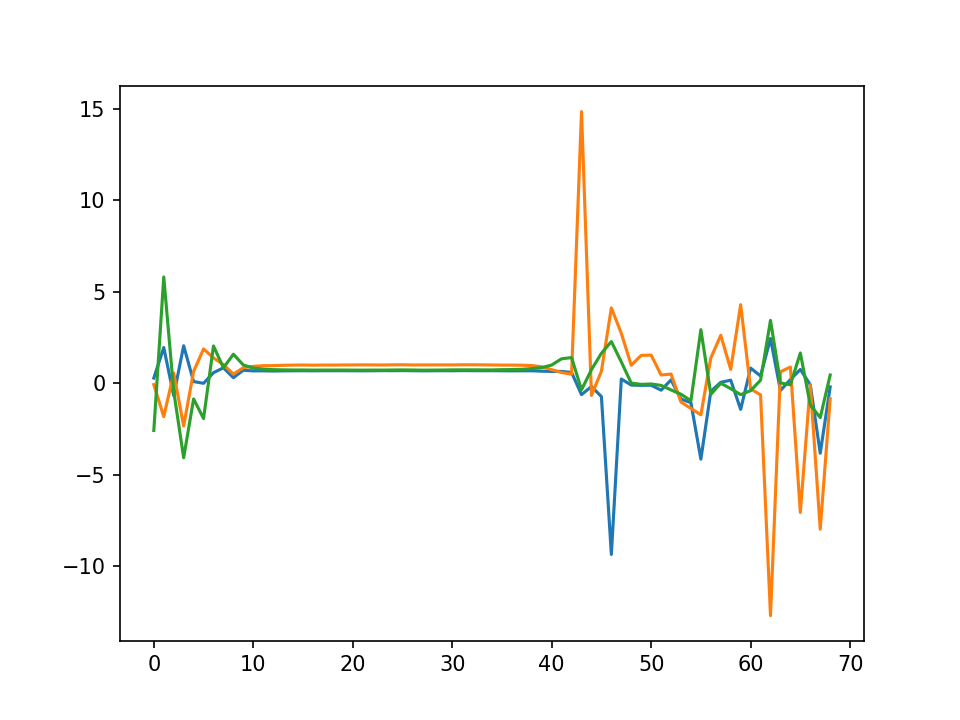

In [30]:
plt.figure()
signal = level_0.intensity_electrons.mean(level_0.axis.xy)
plt.plot(signal[..., 1:] / signal[..., 0:1])

## Level 1 Dataset

<IPython.core.display.Javascript object>


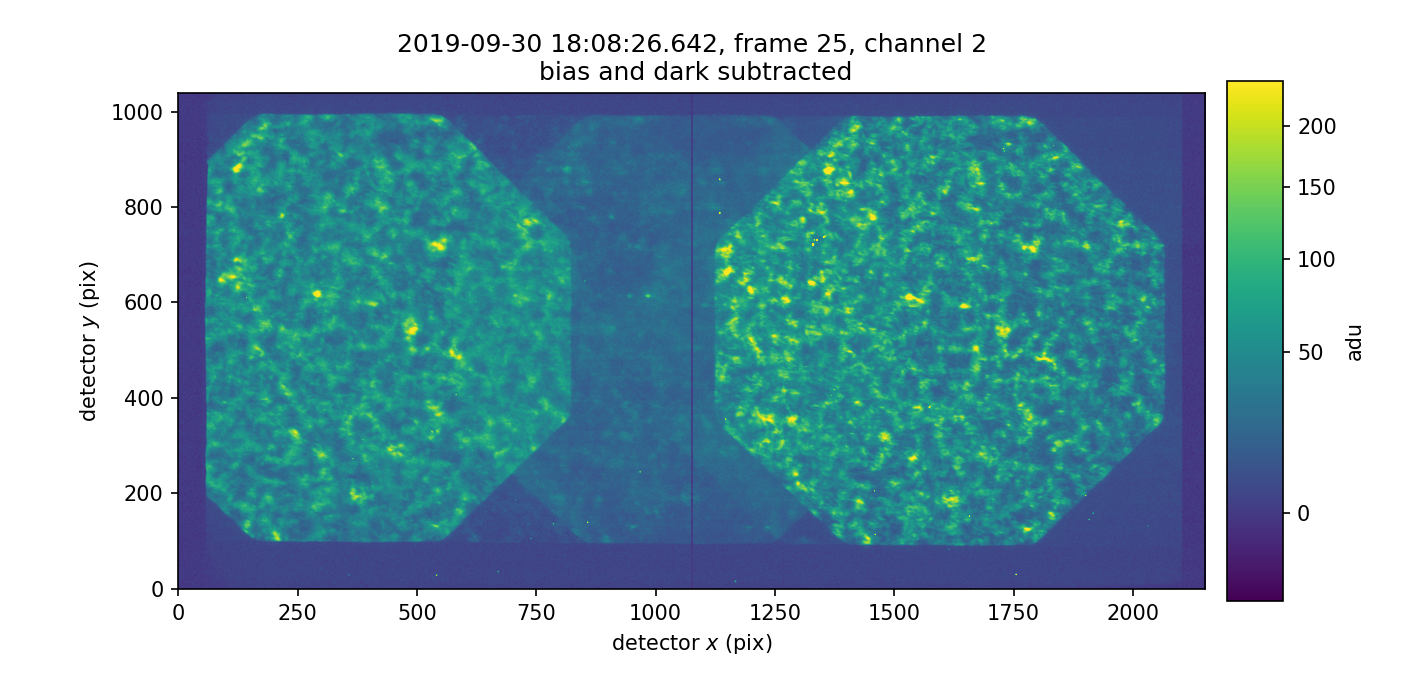

Wall time: 68.2 ms


In [9]:
fig_lev0_blink, ax_lev0_blink = plt.subplots(figsize=(9.5, 4.5), constrained_layout=True)
%time _ = level_0.blink_intensity_nobias_nodark(ax=ax_lev0_blink, time_index=25, channel_index=1, norm_gamma=0.5)

<IPython.core.display.Javascript object>


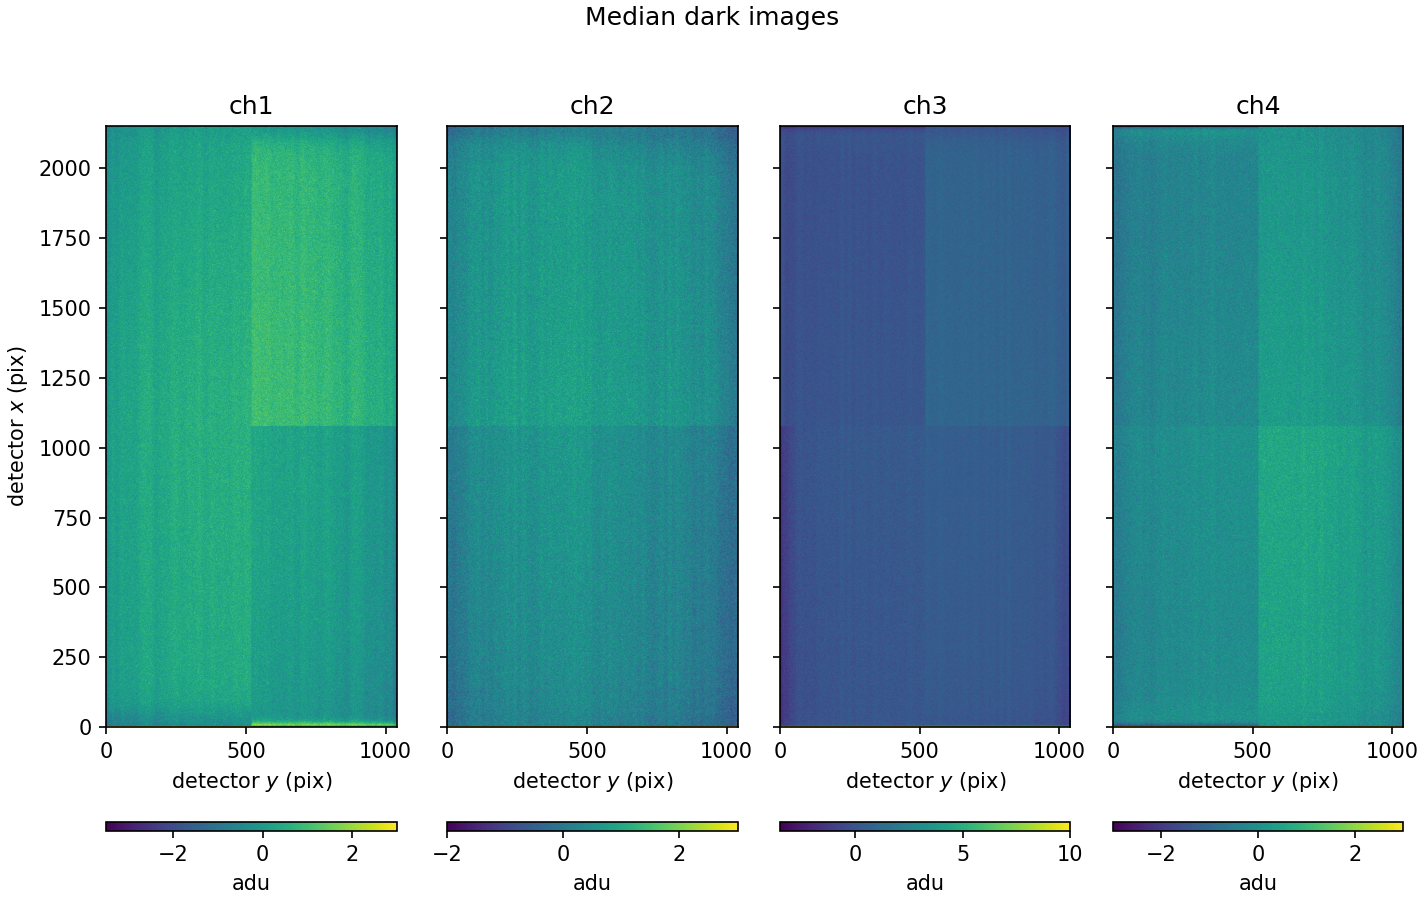

In [10]:
fig_dark, axs_dark = plt.subplots(ncols=4, figsize=(9.5, 6), sharex=True, sharey=True, constrained_layout=True)
_ = level_0.plot_dark(axs=axs_dark)

<IPython.core.display.Javascript object>


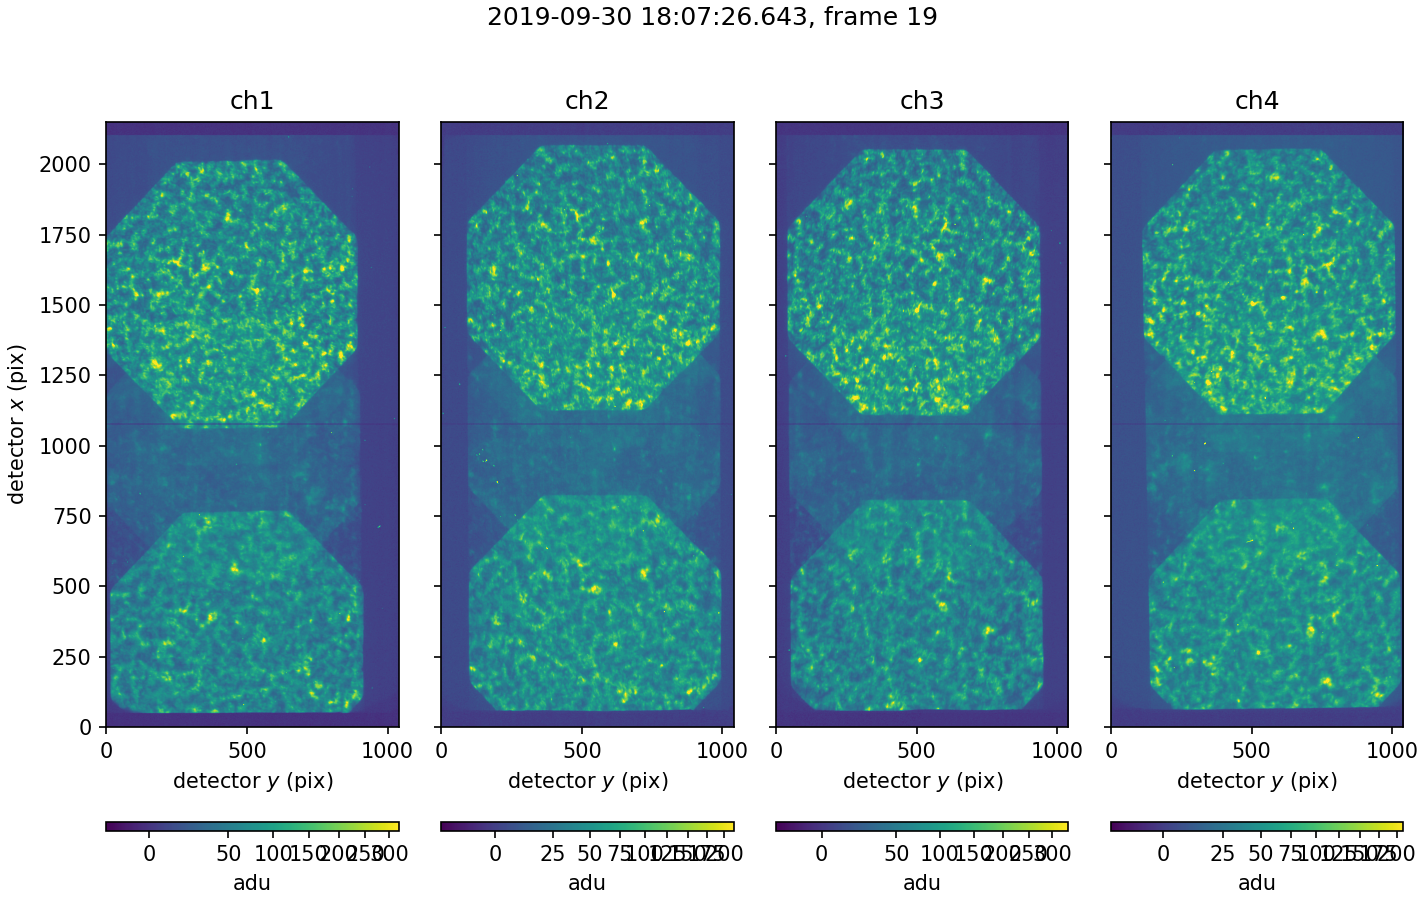

In [11]:
sl=level_0.slice_signal
fig_lev1, axs_lev1 = plt.subplots(ncols=4, figsize=(9.5, 6), sharex=True, sharey=True, constrained_layout=True, squeeze=False)
_ = level_0.animate(
    data=level_0.intensity_nobias_nodark, 
    time_slice=sl,
    axs=axs_lev1, 
    frame_interval=0.1 * u.s, 
    norm_gamma=0.5,
)

In [25]:
level_1 = esis.flight.level_1()
level_1.channel =[0, 1, 2, 3] * u.chan

c:\users\byrdie\appdata\local\programs\python\python37\lib\site-packages\astropy\units\quantity.py:1039: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


In [30]:
level_0.channel

<Quantity [1., 2., 3., 4.] chan>

<IPython.core.display.Javascript object>


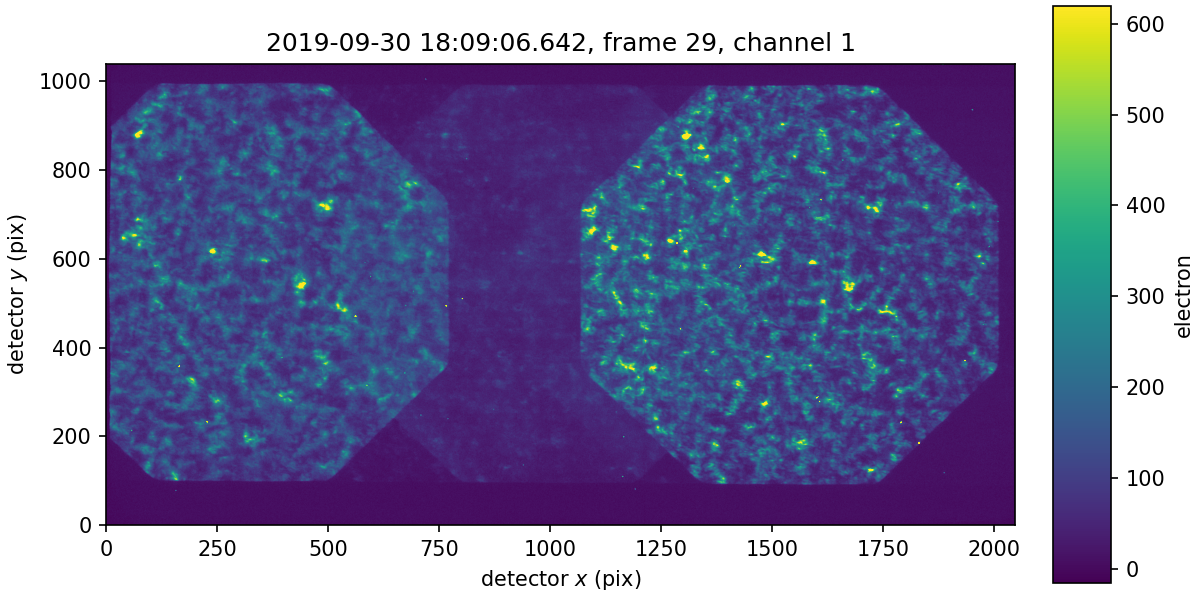

In [29]:
fig_l1, ax_l1 = plt.subplots(figsize=(8,4), constrained_layout=True)
level_1.plot_intensity_channel(ax=ax_l1, time_index=17, channel_index=1);

## Level 2 Dataset

In [ ]:
esis_lev2 = esis.flight.optics.as_measured(field_samples=5, pupil_samples=10)
esis_lev2.filter.clear_radius = 100 * u.mm

In [ ]:
cube_index = 17
cube = level_1.intensity[cube_index].copy()
cube = np.swapaxes(cube, ~1, ~0)
stray_bg = np.percentile(cube.mean(~1), 1, axis=~0)
cube -= stray_bg[..., None, None]
thresh = np.percentile(cube, 99.9)
cube[cube > thresh] = thresh
cube_mean = np.median(cube, axis=(~1, ~0))[..., None, None]
cube = cube * np.median(cube) / cube_mean
cube = cube[..., 32:, :]

In [ ]:
print(cube.shape)

In [ ]:
plt.figure()
plt.imshow(cube[3].T.value)

In [ ]:
%matplotlib inline

In [ ]:
# %time esis_fit1 = esis_lev2.fit_to_images(cube, global_search=False, local_samples=512, plot_steps=False)

In [ ]:
# %time esis_fit2 = esis_lev2.fit_grating_roll_ruling_to_images(cube, 512, False)

In [ ]:
# esis_fit2.detector.pixel_width /= 10

In [ ]:
# %time esis_fit3 = esis_fit2.fit_grating_inclination_twist_to_images(cube, 512, True)

In [ ]:
# %time esis_fit4 = esis_fit3.fit_to_images(cube, global_search=False, local_samples=512, plot_steps=False)

In [ ]:
# %time esis_fit5 = esis_fit4.fit_grating_roll_ruling_to_images(cube, 512, False)

In [ ]:
# %time esis_fit3 = esis_fit2.rough_fit_to_images(cube, 512, 0, 1, True)

In [ ]:
%time esis_fit = esis.flight.optics.as_flown(disk_cache=esis.flight.optics.as_flown_cache.parent / 'optics_as_flown_1.pickle')

In [ ]:
%matplotlib notebook

In [ ]:
ef = esis_fit.copy()
ef.pupil_samples=20

In [ ]:
esis_fit.central_obscuration

In [ ]:
print('grating.roll', ef.grating.roll)
print('grating.inclination', ef.grating.inclination - esis_lev2.grating.inclination)
print('grating.twist', ef.grating.twist)
print('detector.piston', ef.detector.piston - esis_lev2.detector.piston)
print('detector.inclination', ef.detector.inclination - esis_lev2.detector.inclination)
print('detector.roll', ef.detector.roll)
print('detector.twist', ef.detector.twist)
print('grating.ruling_density', ef.grating.ruling_density - esis_lev2.grating.ruling_density)
print('grating.piston', ef.grating.piston - esis_lev2.grating.piston)
print('V_0', ef.vignetting_correction.coefficients[0])
print('V_x', ef.vignetting_correction.coefficients[2])
print('V_y', ef.vignetting_correction.coefficients[3])

In [ ]:
cube_test = level_1.intensity[15].copy()
cube_test = np.swapaxes(cube_test, ~1, ~0)
cube_test = cube_test[..., 32:, :]
cube_test = cube_test / cube_mean
cube_test = np.broadcast_to(cube_test[:, None, ...], cube_test.shape[:1] + (3, ) + cube_test.shape[1:], subok=True)

distortion_fit = ef.rays_output.distortion(2)
domain=1.05*u.Quantity([ef.system.field_min, ef.system.field_max])
wavelength = distortion_fit.wavelength[..., 0, 0]
new_cube = distortion_fit.distort_cube(
    cube=cube_test,
    wavelength=wavelength,
    spatial_domain_input=[[0, 0], cube_test.shape[~1:]] * u.pix,
    spatial_domain_output=domain,
    spatial_samples_output=1024,
    inverse=True,
) 
vignetting = ef.rays_output.vignetting(polynomial_degree=1)
new_cube = vignetting(
    cube=new_cube,
    wavelength=wavelength,
    spatial_domain=domain,
    inverse=True,
).value

c0 = 1
c1 = 2


fig_sum, axs_sum = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8.5, 16), constrained_layout=True)
# new_cube = new_cube / new_cube.nanmean((2,3), keepdims=True)
# new_cube_sum = new_cube.sum(0)
new_cube_sum = new_cube[c1] - new_cube[c0]
# new_cube_sum = new_cube[3] - new_cube[2] + new_cube[1] - new_cube[0]
# new_cube_sum = np.square(new_cube[1::2] - new_cube[::2]).mean((0, 1))
img_sum = axs_sum[0].imshow(
    new_cube_sum[~0], 
    vmax=np.nanpercentile(new_cube_sum, 99.9),
    vmin=np.nanpercentile(new_cube_sum, 1),
#     extent=domain.T.flatten()
)
img_sum = axs_sum[1].imshow(
    new_cube_sum[0], 
    vmax=np.nanpercentile(new_cube_sum, 99),
    vmin=np.nanpercentile(new_cube_sum, 1),
#     extent=domain.T.flatten()
)
fig_sum.colorbar(img_sum, ax=axs_sum, location='bottom')

In [ ]:
from kgpy.plot import CubeSlicer

seq_test = level_1.intensity.copy()
seq_test = np.swapaxes(seq_test, ~1, ~0)
seq_test -= stray_bg[..., None, None]
seq_test = seq_test[..., 32:, :]
seq_test_mean = np.median(seq_test, axis=(~1, ~0))[..., None, None]
seq_test = seq_test * np.median(seq_test) / cube_mean
# stray_bg = np.percentile(seq_test.mean(~1), 1, axis=~0)
# seq_test -= stray_bg[..., None, None]



plt.figure()
plt.plot(seq_test.mean((~1, ~0)))

# seq_test = seq_test / seq_test.mean((0, ~1, ~0))[..., None, None]
seq_test = seq_test - ef.stray_light[..., None, None]
seq_test = np.broadcast_to(seq_test[:, :, None, ...], seq_test.shape[:2] + (3, ) + seq_test.shape[2:], subok=True)

distortion_fit = ef.rays_output.distortion(2)
domain=1.4*u.Quantity([ef.system.field_min, ef.system.field_max])
wavelength = distortion_fit.wavelength[None, ..., 0, 0]
new_seq = distortion_fit.distort_cube(
    cube=seq_test,
    wavelength=wavelength,
    spatial_domain_input=[[0, 0], seq_test.shape[~1:]] * u.pix,
    spatial_domain_output=domain,
    spatial_samples_output=1024,
    inverse=True,
#     fill_value=np.nan,
) 
vignetting = ef.rays_output.vignetting(polynomial_degree=1)
new_seq = vignetting(
    cube=new_seq,
    wavelength=wavelength,
    spatial_domain=domain,
    inverse=True,
)
new_seq = optics.aberration.Vignetting.apply_model(
    model=ef.vignetting_correction,
    cube=new_seq,
    wavelength=wavelength,
    spatial_domain=domain
)

new_images = new_seq[cube_index]

ref_image = new_images[1]

p11 = scipy.signal.correlate(new_images[0, 0], ref_image[0], mode='full') / ref_image.size
p21 = scipy.signal.correlate(new_images[2, 0], ref_image[0], mode='full') / ref_image.size
p31 = scipy.signal.correlate(new_images[3, 0], ref_image[0], mode='full') / ref_image.size
p12 = scipy.signal.correlate(new_images[0, ~0], ref_image[~0], mode='full') / ref_image.size
p22 = scipy.signal.correlate(new_images[2, ~0], ref_image[~0], mode='full') / ref_image.size
p32 = scipy.signal.correlate(new_images[3, ~0], ref_image[~0], mode='full') / ref_image.size

lag11 = np.array(np.unravel_index(np.argmax(p11), p11.shape)) - np.array(p11.shape) // 2
lag21 = np.array(np.unravel_index(np.argmax(p21), p21.shape)) - np.array(p21.shape) // 2
lag31 = np.array(np.unravel_index(np.argmax(p31), p31.shape)) - np.array(p31.shape) // 2
lag12 = np.array(np.unravel_index(np.argmax(p12), p12.shape)) - np.array(p12.shape) // 2
lag22 = np.array(np.unravel_index(np.argmax(p22), p22.shape)) - np.array(p22.shape) // 2
lag32 = np.array(np.unravel_index(np.argmax(p32), p32.shape)) - np.array(p32.shape) // 2

print(lag11, lag21, lag31, lag12, lag22, lag32)

# new_seq[:, 0, 0] = np.roll(new_seq[:, 0, 0], -lag11, axis=(~1, ~0))
# new_seq[:, 2, 0] = np.roll(new_seq[:, 2, 0], -lag21, axis=(~1, ~0))
# new_seq[:, 3, 0] = np.roll(new_seq[:, 3, 0], -lag31, axis=(~1, ~0))
# new_seq[:, 0, ~0] = np.roll(new_seq[:, 0, ~0], -lag12, axis=(~1, ~0))
# new_seq[:, 2, ~0] = np.roll(new_seq[:, 2, ~0], -lag22, axis=(~1, ~0))
# new_seq[:, 3, ~0] = np.roll(new_seq[:, 3, ~0], -lag32, axis=(~1, ~0))

plt.plot(new_seq.mean((~2, ~1, ~0)))

# new_seq = new_seq / np.nanmean(new_seq, axis=(~1, ~0))[..., None, None]

In [ ]:
c0 = 0
c1 = 1
wavl_index = ~0
# seq_min = new_seq.min(1, keepdims=True)
# seq_min = np.percentile(new_seq, 25, 1, keepdims=True)
# new_seq_sum = seq_min[:, 0, ~0]
# new_seq_sum =  new_seq[:, c0, 0] - new_seq[:, c0, ~0]
new_seq_sum = new_seq[:, c1, wavl_index] - new_seq[:, c0, wavl_index]
# new_seq_sum = new_seq[:, 3, wavl_index] - new_seq[:, 2, wavl_index] + new_seq[:, 1, wavl_index] - new_seq[:, 0, wavl_index]
# new_seq_sum = np.median(new_seq, 1)[:, wavl_index]

new_seq_sum = new_seq_sum.value

c = CubeSlicer(
    new_seq_sum, 
    vmin=np.nanpercentile(new_seq_sum, 0.1), 
    vmax=np.nanpercentile(new_seq_sum, 99.9),
    figsize=(7, 7)
)

In [ ]:
iris_cube = observatories.iris.mosaics.load_index()

spatial_rebin_factor = 2
spectral_rebin_factor = 2
spectral_trim = iris_cube.num_wavelength // spectral_rebin_factor * spectral_rebin_factor

rsh = iris_cube.shape[:~2]
rsh += (iris_cube.shape[~2] // spatial_rebin_factor, spatial_rebin_factor, )
rsh += (iris_cube.shape[~1] // spatial_rebin_factor, spatial_rebin_factor, )
rsh += (iris_cube.shape[~0] // spectral_rebin_factor, spectral_rebin_factor, )

iris_cube.intensity = iris_cube.intensity[..., :spectral_trim]
iris_cube.intensity = iris_cube.intensity.reshape(rsh)
iris_cube.intensity = iris_cube.intensity.sum((~4, ~2, ~0))

iris_cube.intensity_uncertainty = iris_cube.intensity_uncertainty[..., :spectral_trim]
iris_cube.intensity_uncertainty = iris_cube.intensity_uncertainty.reshape(rsh)
iris_cube.intensity_uncertainty = iris_cube.intensity_uncertainty.sum((~4, ~2, ~0))

iris_wavelength_nominal = iris_cube.channel[0]

for w, _ in enumerate(iris_cube.wcs.flat):
    wcs = iris_cube.wcs.flat[w].wcs
    wcs.cdelt[~1:] /= 3
    wcs.cdelt[~1:] *= spatial_rebin_factor
    wcs.crpix[~1:] /= spatial_rebin_factor
    wcs.cdelt[~2] *= spectral_rebin_factor
    wcs.crpix[~2] /= spectral_rebin_factor
    wcs.crval[~1] = 50
    wcs.crval[~0] = -100
    wcs.cdelt[~2] = ((wcs.cdelt[~2] << wcs.cunit[~2]) * astropy.constants.c / iris_wavelength_nominal).to(u.km / u.s).value
    wcs.crval[~2] = (((wcs.crval[~2] << wcs.cunit[~2]) - iris_wavelength_nominal) * astropy.constants.c / iris_wavelength_nominal).to(u.km / u.s).value
    wcs.cunit[~2] = u.km / u.s
    
iris_cube.intensity /= np.mean(iris_cube.intensity, axis=(~2, ~1, ~0))[..., None, None, None]

In [ ]:
hs1= plot.HypercubeSlicer(iris_cube.intensity.sum(1).value, wcs_list=iris_cube.wcs[:, 0], width_ratios=(5, 1), height_ratios=(5, 1))

In [ ]:
wcs_sample = iris_cube.wcs.flat[0]

iris_fov_min = wcs_sample.pixel_to_world(0, 0, 0)
iris_fov_max = wcs_sample.pixel_to_world(iris_cube.num_wavelength, iris_cube.num_x, iris_cube.num_y)

# doppler_min = astropy.constants.c * (iris_fov_min[0] - iris_wavelength_nominal) / iris_wavelength_nominal
# doppler_max = astropy.constants.c * (iris_fov_max[0] - iris_wavelength_nominal) / iris_wavelength_nominal
doppler_min =iris_fov_min[0]
doppler_max = iris_fov_max[0]

print(doppler_min, doppler_max)

esis_wavelength_nominal = esis_fit.wavelengths[~0]
esis_wavelength_min = doppler_min * esis_wavelength_nominal / astropy.constants.c + esis_wavelength_nominal
esis_wavelength_max = doppler_max * esis_wavelength_nominal / astropy.constants.c + esis_wavelength_nominal

wavelength = np.linspace(esis_wavelength_min, esis_wavelength_max, iris_cube.num_wavelength)
spatial_domain_input = u.Quantity([u.Quantity(iris_fov_min[1:]), u.Quantity(iris_fov_max[1:])])
# spatial_domain_input /= 3

spatial_domain_output = [[1024, 0], esis_fit.detector.num_pixels] * u.pix

spatial_samples = iris_cube.shape[~2:~0]
iris_projections = esis_fit(
    data=np.moveaxis(iris_cube.intensity, iris_cube.axis.w, ~2),
    wavelength=wavelength,
    spatial_domain_input=spatial_domain_input,
    spatial_domain_output=spatial_domain_output,
    spatial_samples_output=spatial_samples
)
iris_projections = esis_fit(
    data=np.broadcast_to(iris_projections.sum(~2, keepdims=True), iris_projections.shape, subok=True),
    wavelength=wavelength,
    spatial_domain_input=spatial_domain_output,
    spatial_domain_output=spatial_domain_input,
    spatial_samples_output=spatial_samples,
    inverse=True,
)
iris_projections = np.moveaxis(iris_projections, ~2, iris_cube.axis.w)

wavl_trim_sh = iris_cube.num_wavelength // 2 // 2 * 2 * 2

iris_intensity = iris_cube.intensity[..., :wavl_trim_sh]
iris_projections = iris_projections[..., :wavl_trim_sh]

In [ ]:
hs2 = plot.HypercubeSlicer(iris_projections.sum(1).value, wcs_list=iris_cube.wcs[:, 0], width_ratios=(5, 1), height_ratios=(5, 1))

In [ ]:
cnn_inversion = esis.flight.cnn_inversion()
iris_predictions = cnn_inversion.model_inverse.predict(np.nan_to_num(iris_projections), batch_size=1)
iris_predictions[iris_predictions < 0] = 0

In [ ]:
hs3 = plot.HypercubeSlicer(iris_predictions.sum(1), wcs_list=iris_cube.wcs[:, 0], width_ratios=(5, 1), height_ratios=(5, 1))

In [ ]:
hs4 = plot.HypercubeSlicer((iris_intensity.value - iris_predictions).sum(1), wcs_list=iris_cube.wcs[:, 0], width_ratios=(5, 1), height_ratios=(5, 1))

In [ ]:
mask = iris_intensity.sum(~0) > np.percentile(iris_intensity.sum(~0), 90)

moments_true = np.array(moment.percentile.first_four_moments(iris_intensity.value[mask, :]))
moments_recovered = np.array(moment.percentile.first_four_moments(iris_predictions[mask, :]))

moments_true[1] = iris_cube.wcs[0, 0].pixel_to_world(moments_true[1], 0, 0)[0]
moments_recovered[1] = iris_cube.wcs[0, 0].pixel_to_world(moments_recovered[1], 0, 0)[0]

moments_true[2:] *= iris_cube.wcs[0, 0].wcs.cdelt[~2]
moments_recovered[2:] *= iris_cube.wcs[0, 0].wcs.cdelt[~2]

# moments_true[1] += iris_cube.wcs[0, 0].wcs.crval[~2]
# moments_recovered[1] += iris_cube.wcs[0, 0].wcs.crval[~2]


In [ ]:
iris_cube.wcs[0, 0].wcs.crpix[~2]

In [ ]:
xlabels = (
    'true intensity',
    'true shift (km / s)',
    'true width (km / s)',
    'true skew (km / s)'
)
ylabels = (
    'recovered intensity',
    'recovered shift  (km / s)',
    'recovered width  (km / s)',
    'recovered skew  (km / s)'
)
esis.data.inversion.mart.stats.histogram_tetraptych(
    moments_true, moments_recovered, red_line=True, interquartile_contour=True, x_axis_labels=xlabels, y_axis_labels=ylabels);

In [ ]:
seq = level_1.intensity.copy()
seq = np.swapaxes(seq, ~1, ~0)
seq = seq[..., 32:, :]
# seq = seq * np.median(seq) / np.median(seq, axis=(~1, ~0))[..., None, None]
seq = seq / np.median(seq, axis=(~1, ~0))[..., None, None]

esh = list(seq[..., None, :, :].shape)
esh[~2] = iris_cube.num_wavelength
esis_projections = esis_fit(
    data=np.broadcast_to(seq[..., None, :, :], esh, subok=True),
    wavelength=wavelength,
    spatial_domain_input=[[0, 0], seq.shape[~1:]] * u.pix,
    spatial_domain_output=spatial_domain_input,
    spatial_samples_output=spatial_samples,
    inverse=True,
)
esis_projections = np.moveaxis(esis_projections, ~2, iris_cube.axis.w)
esis_projections = esis_projections[..., :wavl_trim_sh]

In [ ]:
hs5 = plot.HypercubeSlicer(esis_projections.sum(1).value, wcs_list=iris_cube.wcs[:, 0], width_ratios=(5, 1), height_ratios=(5, 1))

In [ ]:
esis_predictions = cnn_inversion.model_inverse.predict(np.nan_to_num(esis_projections), batch_size=1)

In [ ]:
hs6 = plot.HypercubeSlicer(esis_predictions.sum(1), wcs_list=iris_cube.wcs[:, 0], width_ratios=(5, 1), height_ratios=(5, 1))

In [37]:
esis

<module 'esis' from 'C:\\Users\\byrdie\\Kankelborg-Group\\ESIS\\esis\\__init__.py'>

In [41]:
opt = esis.flight.optics.as_measured()
opt.detector.convert_electrons_to_photons(1 * u.electron, 630 * u.AA)

<Quantity 0.18292654 ph>

In [41]:
import cupy as cp

In [42]:
a = cp.random.rand(100, 100, 100)

In [43]:
b = a * u.mm

TypeError: unsupported operand type(s) for *: 'cupy.core.core.ndarray' and 'PrefixUnit'